In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import calendar

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold

# Prerequisites (What you should know from Day 1)

Here's what you should understand well from day 1 to be able to understand this notebook. If you don't feel comfortable with any of these topics its HIGHLY recommended that you review it before continuing with this notebook!

- Preprocessing the data with pandas
- What are decision trees
- How to train a decision tree in scikit-learn

# Downloading and Preprocessing the Data (Same as in Day 1)

If you understand this part of the Day 1 notebook, then feel free to skip over reading this part of the notebook since it is exactly the same. 

In [ ]:
# Download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ' -O bikeshare_train.csv

--2022-01-27 20:33:31--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ
Resolving docs.google.com (docs.google.com)... 74.125.203.113, 74.125.203.100, 74.125.203.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jc97pnmmh6l4hsuama7iq5p6sarvbtuf/1643315550000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download [following]
--2022-01-27 20:33:32--  https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jc97pnmmh6l4hsuama7iq5p6sarvbtuf/1643315550000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download
Resolving doc-0s-5c-docs.googleusercontent.com (doc-0s-5c-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to d

In [ ]:
# Load the data with pandas and properly setup the date/time data
bikeshare = pd.read_csv("bikeshare_train.csv")
bikeshare["date_objs"] = bikeshare["datetime"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
# Create columns for different parts of the date/time data
bikeshare["hour"] = bikeshare["date_objs"].apply(lambda x: x.hour)
bikeshare["day"] = bikeshare["date_objs"].apply(lambda x: x.day)
bikeshare["month"] = bikeshare["date_objs"].apply(lambda x: x.month)
bikeshare["year"] = bikeshare["date_objs"].apply(lambda x: x.year)
bikeshare["weekday"] = bikeshare["date_objs"].apply(lambda x: x.weekday())
bikeshare["plot_time"] = bikeshare["datetime"].apply(dates.datestr2num)

bikeshare["month_str"] = bikeshare["month"].apply(lambda x: calendar.month_name[x])
bikeshare["weekday_str"] = bikeshare["weekday"].apply(lambda x: calendar.day_name[x])

# Create column to tell to represent the traffic ammount 
bikeshare["high_traffic"] = bikeshare["count"] > 145
bikeshare["low_traffic"] = bikeshare["count"] < 145


# Create columns for the weather data
def weather_norm(x):
    if x == 1:
        return "clear"
    if x == 2:
        return "overcast"
    if x > 2:
        return "gross"
    
bikeshare["weather_norm"] = bikeshare["weather"].apply(weather_norm)

# Check the distribution of the weather data and preview the dataframe
print(bikeshare["weather_norm"].value_counts())
bikeshare.head()

clear       7192
overcast    2834
gross        860
Name: weather_norm, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,low_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,True,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,True,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,True,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,True,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,True,clear


# Train/Test Splits

Setting data into different groups for training and testing is a very important part of the data sciene workflow. Many of the models we use can easily fit the data set they are trained on perfectly, but this usually results in nonsensical models that are "overfitted" to the data and cannot generalize to any other new  data points. This makes them basically useless. Setting aside some data for testing allows us to simulate this change and perform better evaluations of our model. [Check this resource out for more info on train/test splits.](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)


## Creating the Train/Test Split

Now that we know that using a train/test split is important for properly evaluating our models, let's consider some different ways to potentially create that train/test split. We'll see that we have to be careful when creating our train/test split to make sure that it makes sense. 

### The most naive split

What is the simplest way to create a train/test split? Draw a line at some point in the dataset and take one side to be the train data and the other to be the test data! The following steps detail an easy procedure to do this. 
1.   Pick a size for the test set (in this case, we will use 20% of the data for the test set)
2.   Take the first section of data as the train set
3.   Take the second section of data as the test set



In [ ]:
# Calculate where the cutoff should be if we want 20% of our data to be in the test set
test_set_percentage = 0.2
test_set_size = int(len(bikeshare)*test_set_percentage) 
test_cutoff = len(bikeshare) - test_set_size 

# Take everything before the cutoff to be the train set
bikeshare_train = bikeshare[:test_cutoff]

# Take everything after the cutoff to be the test set 
bikeshare_test = bikeshare[test_cutoff:]

# Lets check to make sure the size of our train and test data seem about correct
print("Size of train data:", len(bikeshare_train))
print("Size of test  data:", len(bikeshare_test))

Size of train data: 8709
Size of test  data: 2177


But doing this split naively can sometimes be a big problem! To see why, lets look at the distribution of the months represented in the train set and the months represented in the test set.

In [ ]:
print("Training set months:")
print(bikeshare_train["month_str"].value_counts())
print('-----------')
print("Test set months:")
print(bikeshare_test["month_str"].value_counts())

Training set months:
May          912
June         912
July         912
April        909
March        901
February     901
January      884
August       558
December     456
November     456
October      455
September    453
Name: month_str, dtype: int64
-----------
Test set months:
December     456
October      456
September    456
November     455
August       354
Name: month_str, dtype: int64


### Improving our sampling method
Notice that our test set only contains 5/12 of the months! This means that whenever we run our model, we are only evaluating our model on its performance during these months. What we really want is to evaluate our model on a little bit of data from every month so, clearly, this method is not what we want for this task. 

So, how can we fix this? Lets think about why the problem is occuring in the first place. The best way to do this is to look at the data!

In [ ]:
bikeshare.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,low_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,True,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,True,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,True,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,True,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,True,clear


If we look at the data, we can quickly realize that the data points are sorted by their date/time! This means that when we are taking the last 20% of the data, we are actually taking the data from the last 20% of dates/times and this is why we only see a few of the months appear in our current test set!

Lets come up with a different way to sample our test data that avoids this problem. An easy way to do this if we want 20% of our data in the test set is to through the data in order and for every 5 data points, we set the first 1 to be test data and the last 4 to be train data. Visually, we can compare the two sampling methods in the following way:

Simplest method: OOOOOOOOOOOOXXX

Improved method: OOOOXOOOOXOOOOX

Now lets try implementing this in code

In [ ]:
# Calculate how often to send data to the test set (in our case for an 80/20 train/test split)
test_size = 0.2
test_modulus = int(1/test_size)

# Set 4/5 data points from each set of 5 data points to be in the train set
bikeshare_train = bikeshare.iloc[bikeshare.index % test_modulus != 0]
# Set the remaining 1 data point from each set of 5 data points to be in the test set
bikeshare_test = bikeshare.iloc[bikeshare.index % test_modulus == 0]

# Lets confirm the size of the train and test set are still about right
print("Size of train data:", len(bikeshare_train))
print("Size of test  data:", len(bikeshare_test))

# Lets examine the distribution of the months in the two datasets
print("Training set months:")
print(bikeshare_train["month_str"].value_counts())
print("Test set months:")
print(bikeshare_test["month_str"].value_counts())

Size of train data: 8708
Size of test  data: 2178
Training set months:
May          730
August       730
October      729
June         729
July         729
December     729
November     728
September    728
April        727
March        721
February     721
January      707
Name: month_str, dtype: int64
Test set months:
July         183
June         183
December     183
November     183
May          182
October      182
August       182
April        182
September    181
March        180
February     180
January      177
Name: month_str, dtype: int64


Notice how now our train and test datasets now have the same distribution of months! If we didn't look at the data, it would seem like these two methods are essentially identical and interchangable. This example shows us that sometimes a very simple modification can make a big difference and why its important to be careful when making our train/test split. 

Now, it might seem like we can always use this second method we have developed and like it will always be better than the first method. In practice, this turns out to be very false. For example, if we had taken 1 out of every 12 data points to be in our test set, our test set would be entirely data points from noon and midnight, with no other times represented! It is important to think about your data carefully before making a decision on how to do your train/test split! Here are some resources to learn more about this problem:

- [The story of a bad train/test split](https://anotherdatum.com/train-test.html)
- [Random Test/Train Splits is Not Always Enough](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/)

## Comparing models with Train/Test Splits

Lets see how we can use the train/test split we created to better understand and compare different models. 

In [ ]:
# Create lists of possible features (Same as in Day 1)
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_sets = {
    "date": date_features,
    "time": time_features,
    "date + time": date_features + time_features,
    "weather": weather_features,
    "all": date_features + time_features + weather_features
}

In [ ]:
# We'll keep track of which classifier was the best
best = 0
best_name = None
best_actual = None
best_predictions = None

test_accuracies = []
train_accuracies = []

# For each feature set, we evaluate our model on both the train and the test set
for set_name, feature_set in feature_sets.items():

    # Create a dummyset with only the features in our feature set
    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    # Use scikit-learn to create our train/test split and train our decision tree
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)

    # Calculate our accuracy on the train and test sets
    train_pred = model.predict(X_train)
    train_accuracy = 100*accuracy_score(y_train, train_pred)
    test_pred = model.predict(X_test)
    test_accuracy = 100*accuracy_score(y_test, test_pred)

    # Keep track of the best model on the test set
    if test_accuracy > best:
        best = test_accuracy
        best_name = set_name
        best_actual = y_test
        best_predictions = test_pred
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    # Display the accuracy on the train and test set for each model
    print(f"Results for {set_name}:")
    print(f"Accuracy on the train set: {train_accuracy:.1f}")
    print(f"Accuracy on the test set: {test_accuracy:.1f}")
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Results for date:
Accuracy on the train set: 66.4
Accuracy on the test set: 62.6
------------------------
Results for time:
Accuracy on the train set: 81.0
Accuracy on the test set: 80.1
------------------------
Results for date + time:
Accuracy on the train set: 100.0
Accuracy on the test set: 90.8
------------------------
Results for weather:
Accuracy on the train set: 90.7
Accuracy on the test set: 68.5
------------------------
Results for all:
Accuracy on the train set: 100.0
Accuracy on the test set: 90.7
------------------------
Best feature set is: date + time 
With: 90.8% accuracy.


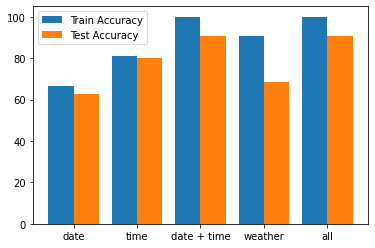

In [ ]:
locs = np.arange(len(test_accuracies))

ax = plt.gca()
ax.bar(locs-0.2, train_accuracies, width=0.4)
ax.bar(locs+0.2, test_accuracies, width=0.4)
ax.set_xticks(locs)
ax.set_xticklabels(list(feature_sets.keys()))
ax.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

If we had just looked at the train set, we would have thought that using date and time alone we could perfectly model the levels of bikeshare traffic. Once we look at the test accuracy, we realize that that is not true at all! While 90% accuracy is pretty great, that 10% of misclassified data demonstrates that our model is definitely not perfect. 

We can also see that the model trained on just date/time is actually better than the model trained on date/time/weather! This is an example of more data not always being better and an example of how our decision tree algorithm does not always converge to the optimal tree, just a pretty good one!

Here are some more resources diving further into comparing models using train/test splits and the convergence of decision trees:

- [Train/Test Splits and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
- [Disadvantages of Decision Trees (this article is pretty technical)](https://www.edupristine.com/blog/decision-trees-development-and-scoring)

# Metrics of Model Quality

While accuracy is great some of the time, there are many cases where it is not a good metric for understanding the performance of our models. Lets explore some alternate methods for evaluating our models and figure out when we should be using them. 

In [ ]:
# Lets keep the predictions from the best tree that we found to use in this section
predictions = best_predictions
actual = np.array(list(best_actual))

### Accuracy

$$ accuracy = \frac{correct \space predictions}{total \space predictions} \times 100 $$

In [ ]:
# Calculating accuracy manually
matches = (predictions == actual).sum() 
accuracy = matches / len(actual)
print(f"Manual accuracy metric: {100*accuracy:.1f}")

Manual accuracy metric: 90.8


In [ ]:
# Calculating accuracy with scikit-learn
accuracy = accuracy_score(actual, predictions)
print(f"scikit-learn accuracy metric: {100*accuracy:.1f}")

scikit-learn accuracy metric: 90.8


#### Pros/Cons the accuracy metric

**Benefit**
- Accuracy is very intuitive and easy to understand

**Weakness**
- Accuracy can sometimes paint an inaccurate picture of the model. For example, consider a model that predicts whether or not there will be an earthquake in LA today. You could get >99% accuracy by just guessing no every time, so accuracy can be very misleading in this case!

### Confusion Matrix

The confusion matrix is a great way to visualize where our model is making errors. Elements on the diagonal represent correct predictions. Elements off the diagonal represent that the model predicted the wrong class.

![Example Confusion Matrix](https://www.mathworks.com/help/examples/nnet/win64/CreateConfusionMatrixChartExample_02.png)
  

In [ ]:
# Generating our confusion matrix manually

# Helper function to display our confusion matrix nicely
def matrix_print(matrix):
    print("           Predictions")
    print(f"Actual    |", end='')
    for pred in list(matrix.keys()):
        print(f"{str(pred).rjust(10)}|", end='')
    print()
    for act in list(matrix.keys()):
        print(f"{str(act).rjust(10)}|", end='')
        for pred in list(matrix.keys()):
            cell = matrix[pred][act]
            print(f"{str(cell).rjust(10)}|", end='')
        print()

# Actually computing our confusion matrix         
def build_confusion_matrix(actual, predictions):
    confusion_matrix = {}
    for pred_value in np.unique(predictions):
        confusion_matrix[pred_value] = {}
        for act_value in np.unique(actual):
            cell_count = 0
            for i in range(len(actual)):
                if predictions[i] == pred_value and actual[i] == act_value:
                    cell_count += 1
            confusion_matrix[pred_value][act_value] = cell_count
    return confusion_matrix

conf_matrix = build_confusion_matrix(actual, predictions)
matrix_print(conf_matrix)

           Predictions
Actual    |     False|      True|
     False|       976|        97|
      True|       103|      1002|


#### Pros/Cons of the confusion matrix

**Benefit**
- Gives us a deeper understanding of our model performance than accuracy alone

**Weakness**
- We don't get a single number out so it is hard to tell which model is "better" when comparing two models

### Cohen's Kappa

$$ \kappa = \frac{accuracy - chance \space agreement}{1 - chance \space agreement}$$


In [ ]:
# Calculating Kappa Manually
matching_by_chance = 0
for label in np.unique(actual):
    predicted_probability = (predictions == label).sum() / len(predictions)
    actual_probability = (actual == label).sum() / len(actual)
    matching_by_chance += (predicted_probability * actual_probability)

print(f"Probability of matching by chance: {matching_by_chance:.3f}")
kappa = (accuracy - matching_by_chance) / (1 - matching_by_chance)
print(f"Manual kappa metric: {kappa:.3f}")

Probability of matching by chance: 0.500
Manual kappa metric: 0.816


In [ ]:
# Calculating Kappa with scikit-learn
kappa = cohen_kappa_score(actual, predictions)
print(f"scikit-learn kappa metric: {kappa:.3f}")

scikit-learn kappa metric: 0.816


#### Pros/Cons of Cohen's Kappa

**Benefit**
- Gives us a single number that evaluates the accuracy of our model and compares it to a simple baseline model -- guessing randomly based on the distribution of the data

**Weakness**
- What threshold denotes a "good" kappa value is highly subjective

### Precision, Recall, and F-Score

$$ Precision = \frac{sucessful \space predictions}{predicted \space positives}$$
$$ Recall = \frac{sucessful \space predictions}{actual \space positives}$$
$$ F \mbox{-} score = \frac{2 \times precision \times recall}{precision + recall}$$

In [ ]:
# Compute Precision, Recall, and F-Score Manually
# Compute number of predictions, number of correct predictions, and number of total positives
predicted_positives = (predictions == True).sum()
actual_positives = (actual == True).sum()
successful_predictions = 0
for i in range(len(predictions)):
    if predictions[i] == True and actual[i] == True:
        successful_predictions += 1

# Compute Precision Manually
precision = successful_predictions / predicted_positives
print(f"Precision: {precision:.3f}")

# Compute Recall Manually
recall = successful_predictions / actual_positives
print(f"Recall: {recall:.3f}")

#Compute F-Score Manually
f = (2*precision*recall)/(precision + recall)
print(f"F-Score: {f:.3f}")

Precision: 0.912
Recall: 0.907
F-Score: 0.909


In [ ]:
# Compute Precision, Recall, and F-Score with a Confusion Matrix
conf_matrix = build_confusion_matrix(actual, predictions)

successful_positives = conf_matrix[True][True]
predicted_positives = 0
for a in conf_matrix[True].keys():
    predicted_positives += conf_matrix[True][a]

precision = successful_positives / predicted_positives
print(f"Precision: {precision:.3f}")

actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p][True]
    
recall = successful_positives / actual_positives
print(f"Recall: {recall:.3f}")

f = (2*precision*recall)/(precision + recall)

print(f"F-Score: {f:.3f}")

Precision: 0.912
Recall: 0.907
F-Score: 0.909


In [ ]:
# Compute Precision, Recall, and F-Score with scikit-learn
precision = precision_score(actual, predictions)
recall = recall_score(actual, predictions)
f = f1_score(actual, predictions)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F-Score: {f:.3f}")


Precision: 0.912
Recall: 0.907
F-Score: 0.909


#### Pros/Cons of F-score

**Benefit**
- Achieves a balance between precision and recall without sacrificing much of either

**Weakness**
- It is hard to interpret, and is not as useful when we care about one of the two components more than the other

**High precision is important when...**
- You are working with limited resources and can’t say yes often
- The stakes for making a mistake are very high

**High recall is important when...**
- It is not very expensive or hard to say yes to everything
- The cost of missing out is greater than the cost of making a mistake

### Additional metric calculation

There are many other metrics that could be used to compare models. Here are a few more:

$$ specificity = \frac{successful \space negatives}{actual \space negatives}$$

$$ sensitivity = \frac{successful \space positives}{actual \space positives} = recall $$

$$ false \space positive \space rate = \frac{false \space positives}{predicted \space positives}$$

$$ false \space negative \space rate = \frac{false \space negatives}{predicted \space negatives}$$

In [ ]:
conf_matrix = build_confusion_matrix(actual, predictions)

# Specificity
successful_negatives = conf_matrix[False][False]
actual_negatives = 0
for p in conf_matrix.keys():
    actual_negatives += conf_matrix[p][False]
specificity = successful_negatives / actual_negatives
print(f"Specificity: {specificity:.3f}")

# Sensitivity
actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p][True]

sensitivity = successful_positives / actual_positives
print(f"Sensitivity: {sensitivity:.3f}")

# False Positive Rate
false_positives = conf_matrix[True][False]
predicted_positives = 0
for a in conf_matrix[True].keys():
    predicted_positives += conf_matrix[True][a]
fpr = false_positives / predicted_positives
print(f"False Positive Rate: {fpr:.3f}")

# False Negative Rate
false_negatives = conf_matrix[False][True]
predicted_negatives = 0
for a in conf_matrix[False].keys():
    predicted_negatives += conf_matrix[False][a]
fnr = false_negatives / predicted_negatives
print(f"False Negative Rate: {fnr:.3f}")

Specificity: 0.910
Sensitivity: 0.907
False Positive Rate: 0.088
False Negative Rate: 0.095


#### Pros/Cons of these metrics

**Benefit**
- In some use cases, certain results have much bigger impacts than other. For example, in a self-driving car, we'd much rather have a false positive detection of a human in front of the car than a false negative. In the case of a false positive, the car detects a human who isn't there and slows down which is fine, but in a false negative the car does not detect a human that is there and runs them over. For these sorts of high sensitivity use cases, these metrics can be very important. 

**Weakness**
- Each of these metrics only paints a partial picture of our model's performance as they are highly specialized

### Using metrics to compare models
Now let's group everything together, all in a single loop, using scikit-learn's built-in calculations for several of the above metrics and compare our models. Notice how the scikit-learn functions for each of the metrics takes in the same inputs in the same order. This allows us to easily interchange functions whenever we want and is one of the truly beautiful parts of scikit-learn's design!

In [ ]:
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_sets = {
    "date": date_features,
    "time": time_features,
    "date + time": date_features + time_features,
    "weather": weather_features,
    "all": date_features + time_features + weather_features
}

In [ ]:
best = 0
best_name = None

precisions = []
recalls = []
kappas = []
accuracies = []

predictions = {}
actual = None

for set_name, feature_set in feature_sets.items():

    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = 100*accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metric_to_optimize = accuracy
    
    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = set_name
        
    predictions[set_name] = y_pred
    actual = np.array(list(y_test))
    
    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Results for {set_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
    precisions.append(precision)
    recalls.append(recall)
    kappas.append(kappa)
    accuracies.append(accuracy)
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Results for date:
[[572 501]
 [314 791]]
Accuracy: 62.6 Kappa: 0.250 Precision: 0.612 Recall: 0.716
------------------------
Results for time:
[[ 717  356]
 [  78 1027]]
Accuracy: 80.1 Kappa: 0.600 Precision: 0.743 Recall: 0.929
------------------------
Results for date + time:
[[ 976   97]
 [ 103 1002]]
Accuracy: 90.8 Kappa: 0.816 Precision: 0.912 Recall: 0.907
------------------------
Results for weather:
[[780 293]
 [392 713]]
Accuracy: 68.5 Kappa: 0.372 Precision: 0.709 Recall: 0.645
------------------------
Results for all:
[[ 962  111]
 [  91 1014]]
Accuracy: 90.7 Kappa: 0.814 Precision: 0.901 Recall: 0.918
------------------------
Best feature set is: date + time 
With: 90.8% accuracy.


Notice how even though our "best" feature set results in a model that performs better for most metrics, it is still worse than some of the other models in recall. Its up to you as the scientist to determine what metrics are most important for a good model in your context!

#### Results by Feature Set

With the loop above, we're able to quickly see the following results:

| Date | Time | Weather | Accuracy  |
|------|------|---------|-----------|
| X    |      |         | 61.3%     |
|      | X    |         | 81.7%     |
|      |      | X       | 66.9%     |
| X    | X    |         | **90.8%** |
| X    | X    | X       | 90.7%     |

### Visualizing model comparisons
We can use plots to visually see the differing performances of our models on two metrics at the same time.

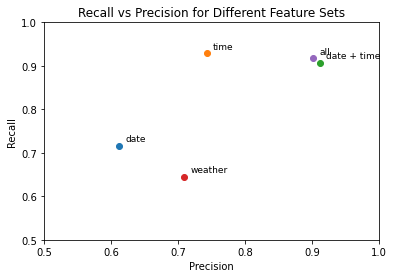

In [ ]:
# Set up plot
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0.5,1)
plt.ylabel("Recall")
plt.title("Recall vs Precision for Different Feature Sets")

# Plot data
names = list(feature_sets.keys())
for i in range(len(precisions)):
    x = precisions[i]
    y = recalls[i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

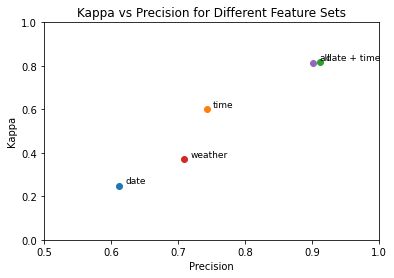

In [ ]:
# Set up plot
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0,1)
plt.ylabel("Kappa")
plt.title("Kappa vs Precision for Different Feature Sets")

# Plot data
names = list(feature_sets.keys())
for i in range(len(kappas)):
    x = precisions[i]
    y = kappas[i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

## Statistical significance of differences with a train/test set

The following code check, for each pair of models that we have trained, whether or not the models are making significantly different predictions. Here, we are using the [Wilcoxon Signed-Rank Test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to get an associated test statistic and p-value for each pair of models.

In [ ]:
matches = {}

for feature_set in predictions.keys():
    boolean_matches = (predictions[feature_set] == actual)
    int_matches = [int(x) for x in boolean_matches]
    matches[feature_set] = int_matches

for set_a in matches.keys():
    for set_b in matches.keys():
        if set_a != set_b:
            matches_a = matches[set_a]
            matches_b = matches[set_b]
            t, p = stats.wilcoxon(matches_a, matches_b)
            print(f"{set_a} || {set_b}: t={t:.1f}, p={p:.3f}")
    print('------')


date || time: t=208502.0, p=0.000
date || date + time: t=44405.0, p=0.000
date || weather: t=170945.0, p=0.000
date || all: t=48530.0, p=0.000
------
time || date: t=208502.0, p=0.000
time || date + time: t=23362.5, p=0.000
time || weather: t=128527.0, p=0.000
time || all: t=21650.0, p=0.000
------
date + time || date: t=44405.0, p=0.000
date + time || time: t=23362.5, p=0.000
date + time || weather: t=41170.0, p=0.000
date + time || all: t=9554.5, p=0.886
------
weather || date: t=170945.0, p=0.000
weather || time: t=128527.0, p=0.000
weather || date + time: t=41170.0, p=0.000
weather || all: t=38720.0, p=0.000
------
all || date: t=48530.0, p=0.000
all || time: t=21650.0, p=0.000
all || date + time: t=9554.5, p=0.886
all || weather: t=38720.0, p=0.000
------


We can see that almost all the pairs of models are pretty different in this cases, indicating that splitting by different features results in models with significantly different predictions! The only two models that don't have significantly different predictions are the models using date/time and date/time/weather, indicating that weather only plays a small role in the model that uses all 3 feature subets!